In [1]:
pacman::p_load(ggplot2,ggpubr,phylotools,geiger,ggtreeExtra,data.table,
               phytools,phyloseq,ggtree,ape,grid,tidyr,wesanderson,
               ggnewscale,stringr,lubridate,ggridges,patchwork,ggstance,dendextend,tidyverse)

In [2]:
sam_with_meta_bact <- data.frame(fread(file.path("..","..","data","sam_with_meta_bact.csv")))
sam_with_meta <- data.frame(fread(file.path("..","..","data","sam_with_meta_euk.csv")))
data_tree_bact <- data.frame(fread(file.path("..","..","data","data_tree_bact.csv")))
data_tree_euk <- data.frame(fread(file.path("..","..","data","data_tree_euk.csv")))

In [3]:
sam_with_meta_bact_filt <- data.frame(fread(file.path("..","..","data","sam_with_meta_bact_filt.csv")))
sam_with_meta_filt <- data.frame(fread(file.path("..","..","data","sam_with_meta_euk_filt.csv")))

In [17]:
mag_abund_frame = data.frame(fread("../../data/mag_abund_res_90perc_top20.csv"))
metadata_file = read.csv(file.path("/vortexfs1", "omics", "alexander", "akrinos", "2021-mendota-18S",
                                   "meta-lakes/meta-lakes-pipeline/data/all_metadata_12May.csv"))
metadata_file["SampleDate"] = "1900-01-01"
for (curr in 1:nrow(metadata_file)) {
    curr_token = metadata_file$Analysis.Project.Analysis.Project.Name[curr]

    if (grepl("ME", curr_token)) {
        listed_meta = unlist(strsplit(curr_token, "-ME"))
        curr_token = unlist(strsplit(listed_meta[length(listed_meta)], "-"))[1]
        sample_date = curr_token
    }
    if (grepl("D",curr_token) & !grepl("Dec",curr_token)) {
        listed_meta = unlist(strsplit(curr_token, "D"))
        sample_date = listed_meta[1]
        curr_token = sample_date
        if (grepl("s", tolower(curr_token)) & !grepl("sep", tolower(curr_token))) {

            listed_meta = unlist(strsplit(curr_token, "s"))
            sample_date = unlist(strsplit(listed_meta[1], "S"))[1]
        } 
    } else if (grepl("s", tolower(curr_token)) & !grepl("sep", tolower(curr_token))) {
        listed_meta = unlist(strsplit(curr_token, "s"))
        sample_date = unlist(strsplit(listed_meta[1], "S"))[1]
    } else if (!is.na(curr_token)) {
        listed_meta = unlist(strsplit(curr_token, "-"))
        sample_date = trimws(unlist(strsplit(listed_meta[1], "deep"))[1])
    } else {
        sample_date = ""
    }

    if (grepl("Fre",sample_date)) {
        sample_date = "Control"
    }
    if (grepl("D",curr_token) & !grepl("Dec",curr_token)) {
        sample_date = unlist(strsplit(sample_date,"D"))[1]

        if (grepl("s", tolower(sample_date)) & !grepl("sep", tolower(sample_date))) {

            sample_date = unlist(strsplit(sample_date, "s"))[1]
        }
        metadata_file$SampleDate[curr] = sample_date
    } else {
        metadata_file$SampleDate[curr] = sample_date
    }


}
mag_abund_frame = mag_abund_frame %>%
    dplyr::left_join(metadata_file)
spiny_abund_frame = data.frame(fread("../../data/spiny_mag_abund_res_90perc.csv")) %>%
    dplyr::left_join(metadata_file)

Joining, by =
"SeqProjID"
Joining, by =
"SeqProjID"


Warning message:
“Removed 6 rows containing missing values (geom_point).”


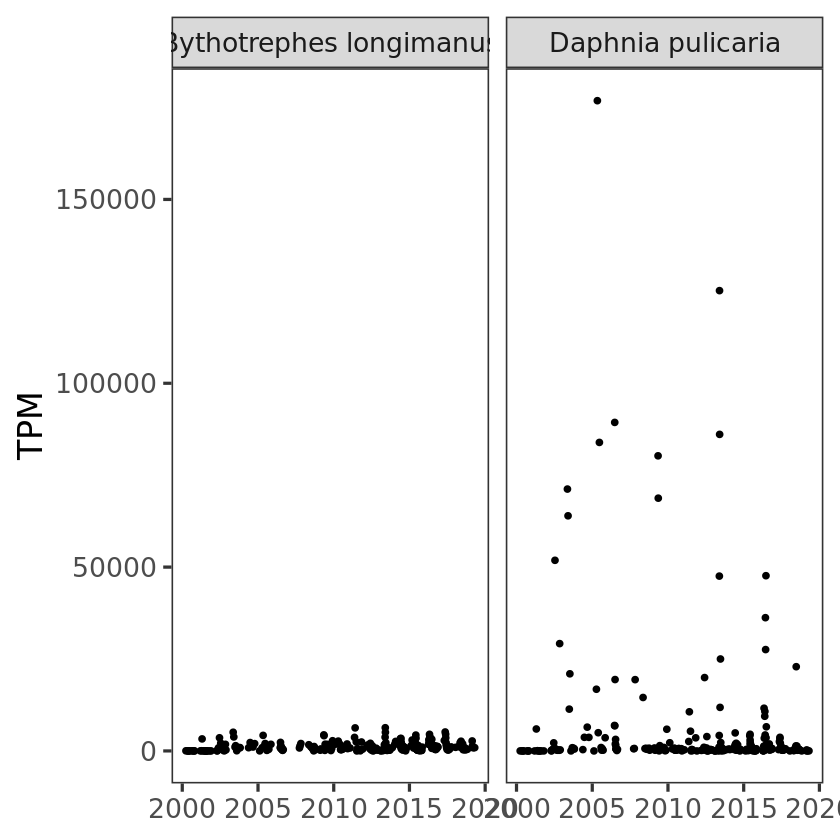

In [22]:
ggplot(spiny_abund_frame %>%
       dplyr::mutate(MAGName = dplyr::case_when(grepl("KMAS001",MAG) ~ "Daphnia pulicaria",
                                                grepl("KMAS002",MAG) ~ "Bythotrephes longimanus"))) + 
        geom_point(aes(x = as.Date(SampleDate,format="%d%b%Y"),
                                           y = TPM)) + facet_wrap(~MAGName) + theme_test(base_size=20) +
        theme(axis.title.x=element_blank())

In [4]:
for_plotting = sam_with_meta %>% dplyr::inner_join(data_tree_euk, by = c("X.rname" = "label","Label"))

for (row_curr in c(1:nrow(for_plotting))) {
    if (trimws(for_plotting$Phylum[row_curr]) == "Metazoa") {
        extra_slots = unlist(strsplit(for_plotting$AllOthers[row_curr],";"))
        if (length(extra_slots) == 11) {
            for_plotting$Phylum[row_curr] = trimws(extra_slots[1])
            for_plotting$Class[row_curr] = trimws(extra_slots[5])
            for_plotting$Order[row_curr] = trimws(extra_slots[9])
            for_plotting$Family[row_curr] = trimws(extra_slots[10])
            for_plotting$Genus[row_curr] = trimws(extra_slots[11])
        } else if (length(extra_slots == 7)) {
            for_plotting$Phylum[row_curr] = trimws(extra_slots[1])
            for_plotting$Class[row_curr] = trimws(extra_slots[3])
            for_plotting$Order[row_curr] = trimws(extra_slots[5])
            for_plotting$Family[row_curr] = trimws(extra_slots[6])
            for_plotting$Genus[row_curr] = trimws(extra_slots[7])
        }
        print(for_plotting[row_curr,])
    }
    if (trimws(for_plotting$Phylum[row_curr]) == "Opisthokonta") {
            for_plotting$Phylum[row_curr] = "Choanozoa"
            for_plotting$Class[row_curr] = "Ichthyosporea"
            for_plotting$Order[row_curr] = "Eccrinida"
            for_plotting$Family[row_curr] = "Piridae"
            for_plotting$Genus[row_curr] = "Pirum"
    }
    
    if (trimws(for_plotting$Phylum[row_curr]) == "Cryptophyceae") {
        for_plotting$Genus[row_curr] = for_plotting$Family[row_curr]
        for_plotting$Family[row_curr] = for_plotting$Order[row_curr]
        for_plotting$Order[row_curr] = for_plotting$Class[row_curr]
        for_plotting$Class[row_curr] = for_plotting$Phylum[row_curr]
        for_plotting$Phylum[row_curr] = "Cryptophyta"
    }
    
    if (trimws(for_plotting$Order[row_curr]) == "Fragilariophyceae") {
            for_plotting$Class[row_curr] = for_plotting$Order[row_curr]
            for_plotting$Order[row_curr] = for_plotting$Species[row_curr]
            for_plotting$Family[row_curr] = ""
            for_plotting$Genus[row_curr] = ""
            for_plotting$Species[row_curr] = ""
    } else if (trimws(for_plotting$Class[row_curr]) == "Bacillariophyta") {
            for_plotting$Class[row_curr] = for_plotting$Order[row_curr]
            for_plotting$Order[row_curr] = for_plotting$Species[row_curr]
            for_plotting$Family[row_curr] = ""
            for_plotting$Genus[row_curr] = ""
            for_plotting$Species[row_curr] = ""
    }
}
curr_cm="RF01960"
for_plotting = for_plotting %>%
    dplyr::mutate(Month = month(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y")),
                  Year = year(as.Date(SampleDate,origin="1970-01-01",format="%d%b%Y"))) %>%
    dplyr::select(-Phylum,-Genus,-Family,-Class,-Order,-Species,-Domain) %>%
    dplyr::left_join(read.csv(file.path("/vortexfs1", "omics", "alexander", "akrinos",
                                        "2021-mendota-18S","refseq-DIAMOND", 
                                        "tree-builder", "2021-12-20_eukaryota", paste0("taxonomy_dict_",curr_cm,
                     ".csv"))),by=c("X.rname"="qseqid")) %>%
    dplyr::mutate(Order = dplyr::case_when(Order == "Coscinodiscophycidae" ~ "Aulacoseirales",
                                           TRUE ~ Order))%>% 
    dplyr::group_by(Label) %>%
    dplyr::mutate(ZScore = (TPM - mean(TPM)) / sd(TPM)) %>%
    dplyr::ungroup()

In [5]:

make_euk_tree <- function(input_tree_file,input_tree_dict,cluster_all,chosen_layout="circular") {
  tree_file <- as.phylo(ggtree(input_tree_file,layout=chosen_layout))
  tree_plot <- as.data.frame(tree_file %>% fortify() %>%
                                   as_tibble()) 
  tree_plot <- tree_plot %>% dplyr::left_join(input_tree_dict,by=c("label"="Labels"))%>% 
        dplyr::left_join(cluster_all, by = c("qseqid" = "query")) %>%
        dplyr::filter((type == "S") | (is.na(type)))
  
  unique_phyla = unique(input_tree_dict$Phylum)
  unique_phyla = unique_phyla[unique_phyla != ""]
  # change this line
  tip_colors <- lapply(unique_phyla, function(x)
  {tree_plot$label[grepl(paste(x, collapse="|"),
                             tree_plot$Phylum)]})
  names(tip_colors) <- unique_phyla
  tip_colors <- Filter(function(x) length(x) > 0, tip_colors)
  #tree_file_to_plot <- as(tree_plot,"phylo") 
  for_input = drop.tip(ape::root(as.phylo(ggtree(tree_plot)), node = 86),
                tip=extract.clade(alveolate_tree,node=107)$tip.label[-1],subtree=FALSE)
  tree_to_plot <- groupOTU(for_input, tip_colors,
                              overlap="overwrite")
                       
  data_tree <- as.data.frame(ggtree(tree_to_plot)$data) %>%
        dplyr::left_join(input_tree_dict,by=c("label"="Labels"))%>% 
        dplyr::left_join(cluster_all, by = c("qseqid" = "query")) %>%
        dplyr::filter((type == "S") | (is.na(type)))
  data_tree = data_tree %>%
      dplyr::mutate(Metagenome = dplyr::case_when(grepl("rRNA",label) ~ "MG",
                                                  TRUE ~ "Ref")) %>%
      dplyr::mutate(Label = dplyr::case_when(Label == Label ~ Label,
                                      TRUE ~ "Ref"),
                    type = dplyr::case_when(Metagenome != "Ref" ~ type,
                                      TRUE ~ "S")) %>%
      dplyr::filter(type == "S")
  data_tree = data_tree %>%
    #dplyr::left_join(input_tree_dict,by=c("label"="Labels")) %>%
    dplyr::mutate(Metagenome = 
                    dplyr::case_when(Metagenome  == "Ref" ~ "Ref",
                                     Metagenome == "MG" ~ "MG",
                                     TRUE ~ "None"))
  return(data_tree)
}


In [7]:
tax_table = read.csv(file.path("/vortexfs1/omics/alexander/akrinos/2021-mendota-18S",
                   "MendotaMAGs/eukulele-snake/marmmetspplusjgi/taxonomy-table.txt"), sep="\t")
metazoan_tree = read.tree(file.path("/vortexfs1/omics/alexander/akrinos/2021-mendota-18S",
                           "refseq-DIAMOND/tree-builder/2021-12-27_metazoa/iqtree_select/total_tree_RF01960.treefile"
                                     ))
metazoan_tree = ape::root(as.phylo(ggtree(read.tree(file.path("/vortexfs1/omics/alexander/akrinos/2021-mendota-18S",
                           "refseq-DIAMOND/tree-builder/2021-12-27_metazoa",
                           "iqtree_select/total_tree_RF01960.treefile"))) + 
                            geom_text(aes(label=label))), node = 32)
metazoan_tree = drop.tip(metazoan_tree,tip=extract.clade(metazoan_tree,node=48)$tip.label[-1],subtree=FALSE)

new_mag_names = read.csv("/vortexfs1/omics/alexander/akrinos/2021-mendota-18S/new_mag_names.csv")
data_frame_metazoan <- as.data.frame(metazoan_tree %>% fortify() %>% as_tibble()) %>%
    dplyr::left_join(tax_table, by=c("label"="Source_ID")) %>%
    dplyr::mutate(label = vapply(strsplit(label,"\\."), `[`, 1, FUN.VALUE=character(1))) %>%
    dplyr::left_join(new_mag_names, by=c("label"="bin")) %>%
    dplyr::select(-Genus,-Family,-Class,-Order,-Species) %>%
    dplyr::left_join(read.csv(file.path("/vortexfs1", "omics", "alexander", "akrinos",
                                        "2021-mendota-18S","refseq-DIAMOND", 
                                        "tree-builder", "2021-12-27_metazoa",
                                        paste0("taxonomy_dict_",curr_cm,
                     ".csv"))),by=c("label"="qseqid")) %>%
    dplyr::mutate(Type = dplyr::case_when(grepl("Ga",label) ~ "MG",
                                          grepl("k1",label) ~ "Mendota reference",
                                   TRUE ~ "NCBI reference")) %>%
    dplyr::mutate(NewLab = dplyr::case_when(Phylum == "Ochrophyta"~ "Outgroup",
                                   TRUE ~ Order))%>%
    dplyr::mutate(NewLabGenus = dplyr::case_when(Phylum == "Ochrophyta"~ "",
                                                 !is.na(Genus) ~ Genus,
                                   TRUE ~ ""))%>%
    dplyr::mutate(NewSize = dplyr::case_when(Phylum == "Ochrophyta"~ "Outgroup",
                                   TRUE ~ ""))

In [8]:
## get season
getOurSeason <- function(date) {
    if (is.na(date)) {
        return("")
    }
    if (grepl("D",date) & !grepl("Dec",date)) {
        date = unlist(strsplit(date,"D"))[1]
    }
    if (grepl("Mendota",date)) {
        return("")
    }
    d <- as.POSIXlt(date, format="%d%b%Y")
    
    curr_year = format(as.Date("16May2013",format="%d%b%Y"),"%Y")
    WS <- as.POSIXlt(paste0(as.character(curr_year),"-12-15"), format = "%Y-%m-%d") # Winter Solstice
    SE <- as.POSIXlt(paste0(as.character(curr_year),"-03-15"),  format = "%Y-%m-%d") # Spring Equinox
    SS <- as.POSIXlt(paste0(as.character(curr_year),"-06-15"),  format = "%Y-%m-%d") # Summer Solstice
    FE <- as.POSIXlt(paste0(as.character(curr_year),"-09-15"),  format = "%Y-%m-%d") # Fall Equinox


    if (((d$yday >= WS$yday) & (d$yday < SE$yday)) | (d$yday < SE$yday)) {
        return("Winter")
    } else if ((d$yday >= SE$yday) & (d$yday < SS$yday)) {
        return("Spring")
    } else if ((d$yday >= SS$yday) & (d$yday < FE$yday)) {
        return("Summer")
    } else {
        return("Fall")
    }
}

In [14]:
t_test_2010 <- function(for_plotting, label, test = "ks", alternative="greater", thres_year = 2010) {
    pre_2010 <- for_plotting %>% dplyr::filter(Label == label) %>%
        dplyr::filter(Year <= thres_year)
    post_2010 <- for_plotting %>% dplyr::filter(Label == label) %>%
        dplyr::filter(Year > thres_year)
    if (test == "ks") {
        return(ks.test(pre_2010$TPM, post_2010$TPM))
    } else if (test == "t") {
        # if greater, pre-2010 is greater than post-2010. if less, pre-2010 is less than post-2010.
        return(t.test(pre_2010$TPM, post_2010$TPM,alternative=alternative))
    }
}
categorize_vals = data.frame()
for_plot_tax = for_plotting %>% dplyr::distinct(Phylum,Order,Class,Genus,Family,Label)
for (curr_ind in c(1:nrow(for_plot_tax))) {
    curr = for_plot_tax$Label[curr_ind]
    curr_pval = t_test_2010(for_plotting, curr, test = "t", alternative="less", thres_year = 2010)$p.value
    if (curr_pval <= 0.05) {
        curr_df = data.frame("Label"=curr, "p-value"=curr_pval,"Phylum"=trimws(for_plot_tax$Phylum[curr_ind]),
                             "Order"=trimws(for_plot_tax$Order[curr_ind]),
                             "Class" = trimws(for_plot_tax$Class[curr_ind]),
                             "Genus" = trimws(for_plot_tax$Genus[curr_ind]),
                             "Family" = trimws(for_plot_tax$Family[curr_ind]),
                             "Verdict"="IncreasedPost2010")
    } else if (curr_pval >= 0.95) {
        curr_df = data.frame("Label"=curr, "p-value"=curr_pval,"Phylum"=trimws(for_plot_tax$Phylum[curr_ind]),
                             "Order"=trimws(for_plot_tax$Order[curr_ind]),
                             "Class" = trimws(for_plot_tax$Class[curr_ind]),
                             "Genus" = trimws(for_plot_tax$Genus[curr_ind]),
                             "Family" = trimws(for_plot_tax$Family[curr_ind]),
                             "Verdict"="DecreasedPost2010")
    } else {
        curr_df = data.frame("Label"=curr, "p-value"=curr_pval, "Phylum"=trimws(for_plot_tax$Phylum[curr_ind]),
                             "Order"=trimws(for_plot_tax$Order[curr_ind]),
                             "Class" = trimws(for_plot_tax$Class[curr_ind]),
                             "Genus" = trimws(for_plot_tax$Genus[curr_ind]),
                             "Family" = trimws(for_plot_tax$Family[curr_ind]),
                             "Verdict"="NoChange")
    }
    categorize_vals = categorize_vals %>% dplyr::bind_rows(curr_df)
}
categorize_vals$Verdict[p.adjust(categorize_vals$p.value, "BH") <= 0.05] = "IncreasedPost2010"
categorize_vals$Verdict[p.adjust(1-categorize_vals$p.value, "BH") <= 0.05] = "DecreasedPost2010"
categorize_vals$Verdict[(p.adjust(1-categorize_vals$p.value, "BH") > 0.05) &
                        (p.adjust(categorize_vals$p.value, "BH") > 0.05)] = "NoChange"

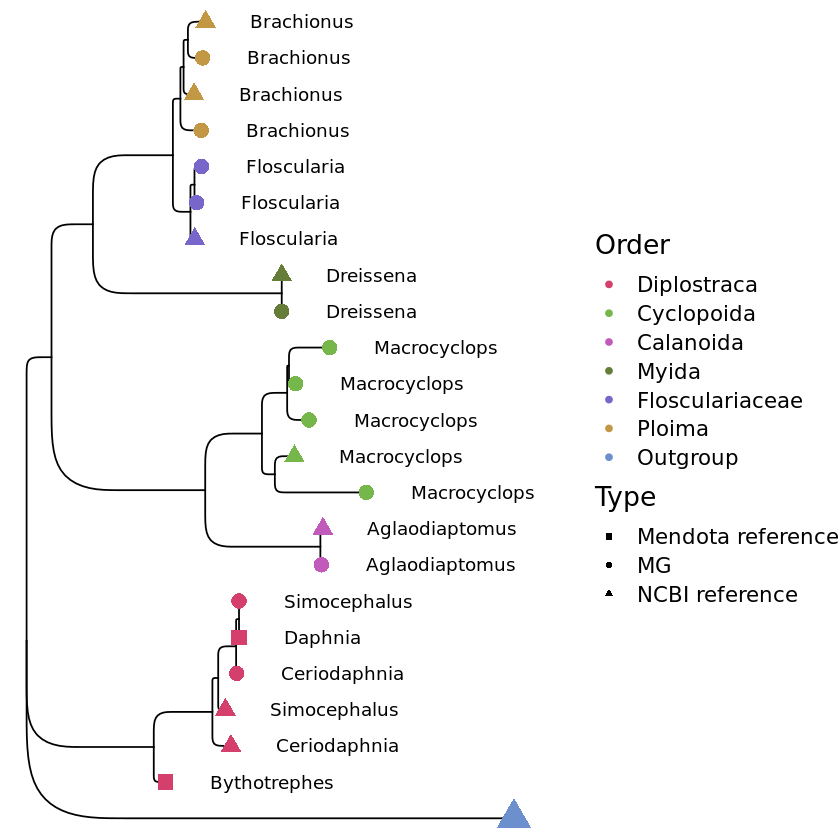

In [29]:
distinct_cols = c("#9f4764", "#58cb5f", "#be54c4", "#4fa433", "#7166d9", "#b0bf2e", "#8b57a1", 
                  "#92bc43", "#d24790", "#55bd81", "#d23d55", "#51c6c0", "#d24b29", "#60a2d7", 
                  "#de882f", "#6077c3", "#d0b13d", "#d08dce", "#417d23", "#e07f89", "#408147", 
                  "#e98060", "#338b70", "#a35630", "#77902d", "#d4a268", "#636f2d", "#9fb56c", 
                  "#86672d", "#9d8527", "black")
distinct_cols = c("#d4406b","#76b74b","#c25abc","#657d39","#7966ca",
                  "#c39844","#6c8fce","#c8603e","#4db598","#bd6a8e")
metazoan_tree = (ggtree(data_frame_metazoan,layout="roundrect") + 
    geom_tippoint(aes(col=NewLab,shape=Type,size=NewSize)) + 
    scale_color_manual(values=distinct_cols, name="Order", 
                       breaks = c(unique(data_frame_metazoan$NewLab),""),
                       labels = c(unique(data_frame_metazoan$NewLab),"Outgroup"),
                      na.value="transparent", na.translate = F) + 
    geom_tiplab(aes(label=NewLabGenus), offset=0.05) +  
    scale_shape_manual(values=c(15,16,17))+
    scale_size_manual(values=c(4,7))+ guides(size="none") +
    theme_void(base_size=16))#+ ylim2(heatmap_plot))
                 
metazoan_tree

In [30]:
for_heatmap = data_frame_metazoan %>%
    dplyr::left_join(for_plotting %>%
    dplyr::mutate(Season = sapply(as.Date(for_plotting$SampleDate,format="%d%b%Y"),getOurSeason)) %>%
    dplyr::mutate(Year = format(as.POSIXct(SampleDate,format="%d%b%Y"),"%Y")) %>%
    dplyr::select(Season,SampleDate,X.rname,TPM,Year,Label), 
                     by = c("label"="X.rname")) %>%
    dplyr::left_join(categorize_vals %>% dplyr::filter(Verdict == "IncreasedPost2010") %>% 
                     dplyr::select(Label,Verdict),
                    by="Label")

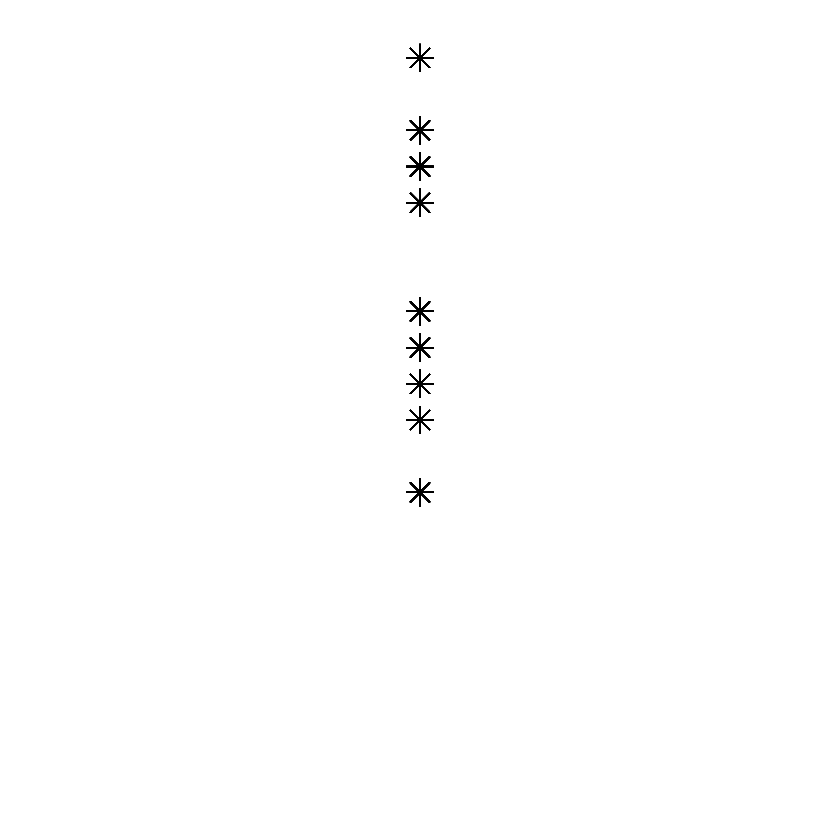

In [31]:
verdict_plot = ggplot(for_heatmap %>% 
                      dplyr::mutate(color_pt = dplyr::case_when(Verdict == "IncreasedPost2010" ~ "true",
                                                             TRUE ~ "none"))) + 
    geom_point(aes(y = y, x = 0, color = color_pt),pch=8,size=5) + theme_void(base_size=16) + xlim(-0.5,0.5) + 
    scale_color_manual(breaks=c("true","none"), values = c("black","transparent")) + 
    theme(legend.position="none") + aplot::ylim2(metazoan_tree)
verdict_plot

`summarise()` has
grouped output by
'Label', 'Year',
'Season'. You can
override using the
`.groups` argument.


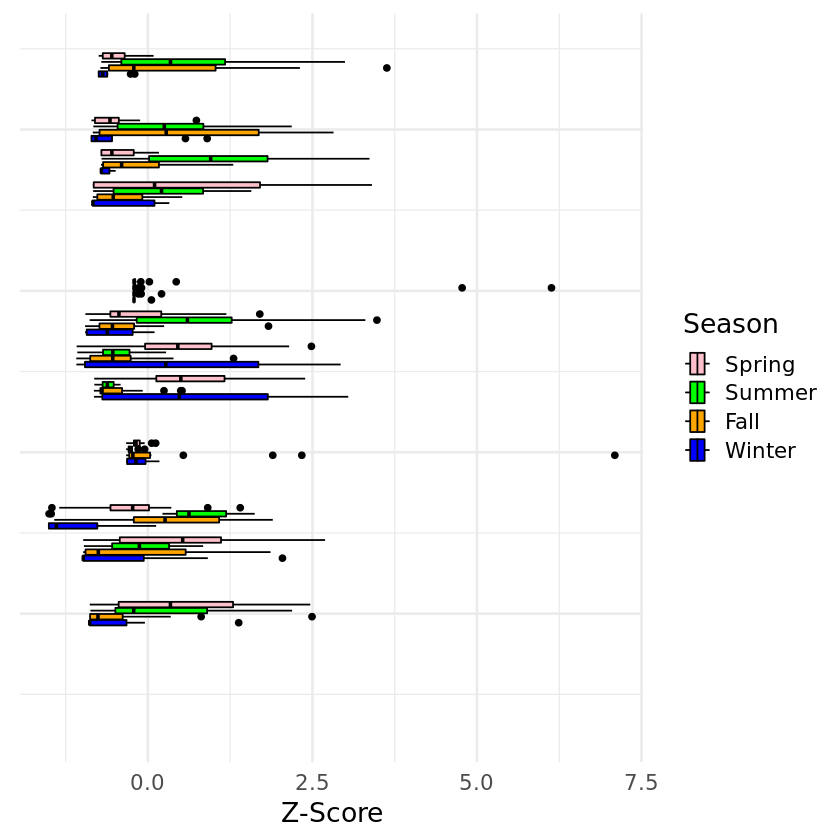

In [44]:
boxplot_plot = ggplot(for_heatmap %>% dplyr::group_by(Label,Year,Season,y) %>%
     dplyr::summarize(TPM = mean(TPM, na.rm = TRUE)) %>%
     dplyr::filter(!is.na(Season) & !is.na(Year)) %>%
     dplyr::group_by(Label,y) %>% dplyr::mutate(ZScore = (TPM - mean(TPM,na.rm=TRUE))/sd(TPM,na.rm=TRUE))) + 
    geom_boxploth(aes(x = ZScore, y = y, group = factor(paste0(Season,y),unique(paste0(c("Spring","Summer","Fall","Winter"),
                                                                                       y))), 
                      fill = factor(Season,levels=c("Spring","Summer","Fall","Winter"))), 
                  color="black")+theme_minimal(base_size=16) +
    theme(axis.title.y=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks.y=element_blank()) +  
    scale_shape_manual(values=c(21,22,23,24),name="Season") + xlab("Z-Score") + 
    scale_fill_manual(name="Season",
                            breaks = c("Spring","Summer","Fall","Winter"),
                            labels = c("Spring","Summer","Fall","Winter"),
                            values=c("pink","green","orange","blue"),na.value="black") + 
    aplot::ylim2(metazoan_tree)
boxplot_plot

`summarise()` has
grouped output by
'Label', 'Year',
'Season'. You can
override using the
`.groups` argument.


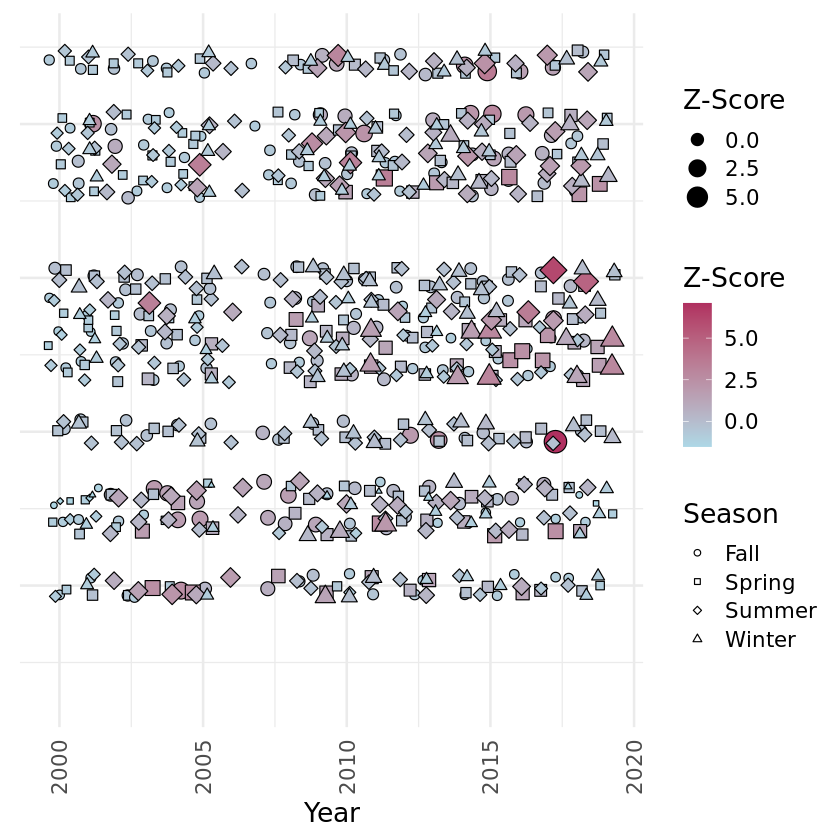

In [47]:
library(aplot)
heatmap_plot = ggplot(for_heatmap %>% dplyr::group_by(Label,Year,Season,y) %>%
     dplyr::summarize(TPM = mean(TPM, na.rm = TRUE)) %>%
     dplyr::filter(!is.na(Season) & !is.na(Year)) %>%
     dplyr::group_by(Label,y) %>% dplyr::mutate(ZScore = (TPM - mean(TPM,na.rm=TRUE))/sd(TPM,na.rm=TRUE))) + 
    geom_jitter(aes(x = as.numeric(Year), y = y, size = ZScore, fill = ZScore,
                   shape = factor(Season)),color="black")+
    scale_size(name="Z-Score") + 
    scale_fill_gradient(low="light blue", high = "maroon",name="Z-Score") + theme_minimal(base_size=16) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1),
          axis.title.y=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks.y=element_blank()) +  
    scale_shape_manual(values=c(21,22,23,24),name="Season") + xlab("Year")+ ylim2(metazoan_tree)

heatmap_plot

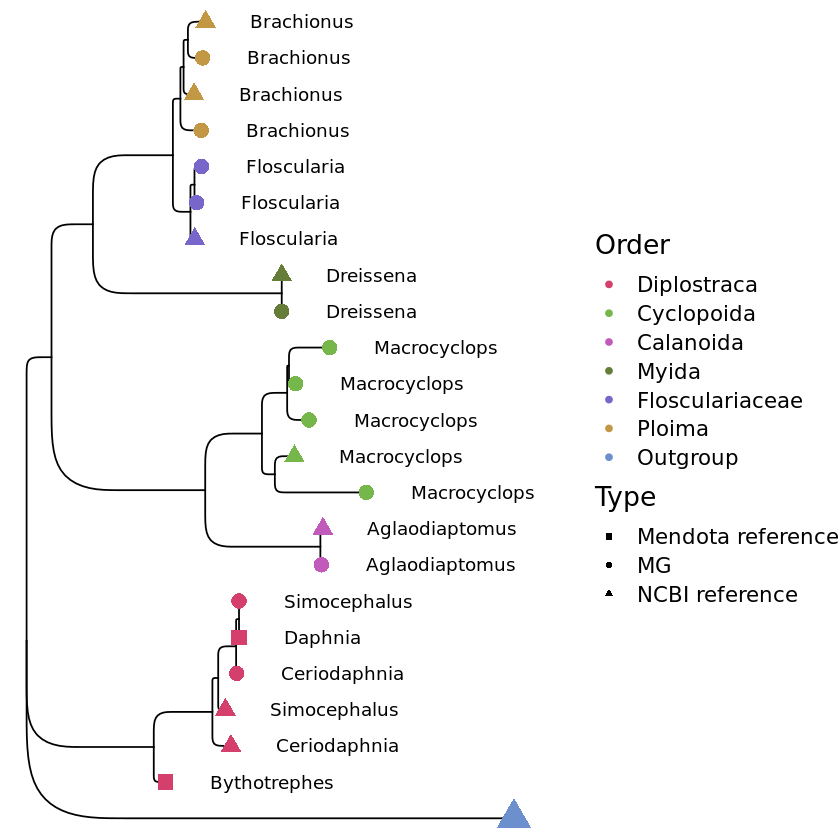

In [48]:
distinct_cols = c("#9f4764", "#58cb5f", "#be54c4", "#4fa433", "#7166d9", "#b0bf2e", "#8b57a1", 
                  "#92bc43", "#d24790", "#55bd81", "#d23d55", "#51c6c0", "#d24b29", "#60a2d7", 
                  "#de882f", "#6077c3", "#d0b13d", "#d08dce", "#417d23", "#e07f89", "#408147", 
                  "#e98060", "#338b70", "#a35630", "#77902d", "#d4a268", "#636f2d", "#9fb56c", 
                  "#86672d", "#9d8527", "black")
distinct_cols = c("#d4406b","#76b74b","#c25abc","#657d39","#7966ca",
                  "#c39844","#6c8fce","#c8603e","#4db598","#bd6a8e")
metazoan_tree = (ggtree(data_frame_metazoan,layout="roundrect") + 
    geom_tippoint(aes(col=NewLab,shape=Type,size=NewSize)) + 
    scale_color_manual(values=distinct_cols, name="Order", 
                       breaks = c(unique(data_frame_metazoan$NewLab),""),
                       labels = c(unique(data_frame_metazoan$NewLab),"Outgroup"),
                      na.value="transparent", na.translate = F) + 
    geom_tiplab(aes(label=NewLabGenus), offset=0.05) +  
    scale_shape_manual(values=c(15,16,17))+
    scale_size_manual(values=c(4,7))+ guides(size="none") +
    theme_void(base_size=16))#+ ylim2(heatmap_plot))
                 
metazoan_tree

In [60]:
mag_spiny_water = ggplot(spiny_abund_frame %>%
       dplyr::mutate(MAGName = dplyr::case_when(grepl("KMAS001",MAG) ~ "Daphnia pulicaria",
                                                grepl("KMAS002",MAG) ~ "Bythotrephes longimanus"),
                     Order = "Diplostraca")) + 
        geom_point(aes(x = as.Date(SampleDate,format="%d%b%Y"),
                                           y = TPM,fill=Order),size=3,pch=21) + 
    facet_wrap(~MAGName,scales="free_y") + theme_test(base_size=20) +
        theme(axis.title.x=element_blank())+ 
    scale_fill_manual(values=distinct_cols, name="Order", 
                       breaks = c(unique(data_frame_metazoan$NewLab),""),
                       labels = c(unique(data_frame_metazoan$NewLab),"Outgroup"),
                      na.value="transparent", na.translate = F) + theme(legend.position="none")+
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1))

Warning message:
“Removed 6 rows containing missing values (geom_point).”
Warning message:
“Removed 6 rows containing missing values (geom_point).”
Warning message:
“Removed 6 rows containing missing values (geom_point).”


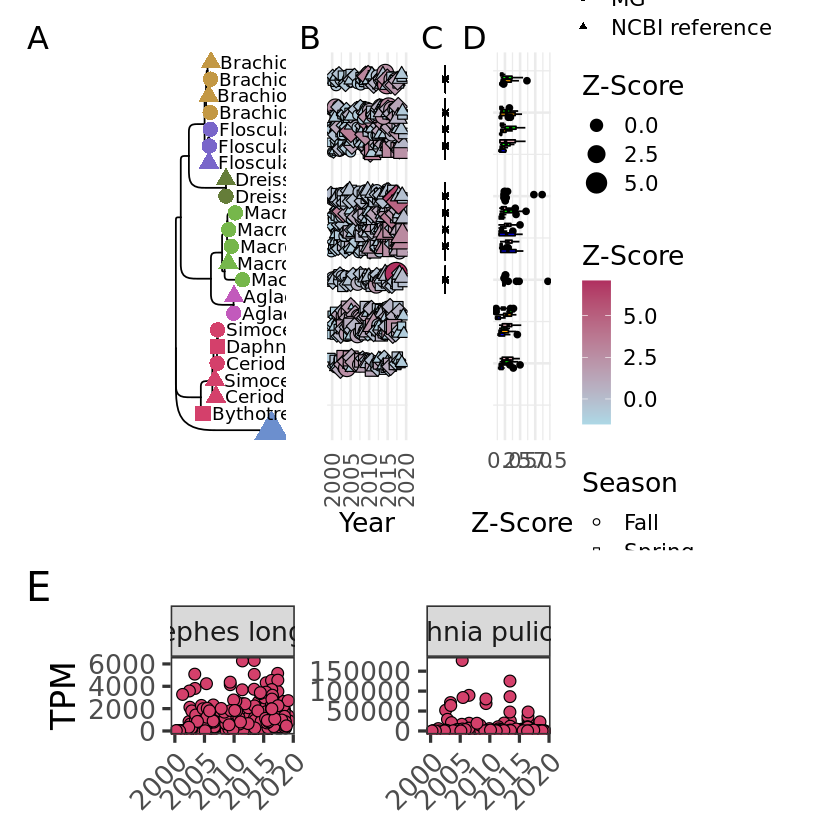

In [64]:
((metazoan_tree | heatmap_plot | verdict_plot | boxplot_plot)+
 plot_layout(guides = 'collect',widths=c(2,1.4,0.1,1)))/ (mag_spiny_water)+ 
    plot_layout(guides = 'collect',widths=c(2,1.4,0.1,1),heights=c(1,0.2)) + plot_annotation(tag_levels = 'A')
ggsave("../../figures/metazoan_facetted_plot.png",dpi=400,width=12,height=12,units="in")
ggsave("../../figures/metazoan_facetted_plot.pdf",dpi=400,width=12,height=12,units="in")

In [ ]:

ggsave("../../figures/metazoan_facetted_plot.png",dpi=400,width=12,height=12,units="in")